## 1. 필요한 패키지 로드

In [1]:
# Viola-Jones algorithm stencil code 
# Written by Soochahn Lee for Computer Vision @ Kookmin University

import csv
import sys
import argparse
import numpy as np
import scipy.io as scio

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

%load_ext autoreload 
%autoreload 2

from skimage import io, filters, feature, img_as_float32
from skimage.transform import rescale
from skimage.color import rgb2gray

import student as student

### size of haar_like_feature ###
hlf_sz = (18,18)

## 2. 실험용 데이터 파일 로딩 함수 정의

실험용 영상 DB를 읽어오고, 영상 사이즈, 컬러/흑백, 픽셀 값 범위 ([0-255]->[0.0 1.0]) 등 포맷을 적절하게 조정하는 함수를 구현하시오. (해당 함수 자유롭게 외부 자료 참고하여 작성하여 됨을

In [2]:
# load positve and negative dataset
DATA_NUM = 1000
# positive data: size n_p x h x w, where n_p = number of positive images and h_i, w_i are width and height of images
data_pos = student.load_folder_imgs('../data/pos', hlf_sz)[:DATA_NUM,:,:]
# negative data: size n_n x h x w, where n_n = number of negative images and h_i, w_i are width and height of images
data_neg = student.load_folder_imgs('../data/neg', hlf_sz)[:DATA_NUM,:,:]

# concatenate all images
n_p = data_pos.shape[0]
n_n = data_neg.shape[0]
data = np.row_stack([data_pos, data_neg])
# create ndarray to store positive/negative labels
labels = np.row_stack([np.ones([n_p,1]), np.zeros([n_n,1])])
weights = np.row_stack([np.ones([n_p,1]), np.ones([n_n,1])])

## 3. Integral Image 함수 선언 및 계산

아래 함수 호출을 통해 integral image들이 계산되도록 student.py 파일에 있는 get_integral_images(data) 함수를 구현하시오.

In [380]:
print(data[0].shape)
print(data[0].shape[0])

(18, 18)
18


In [381]:
iimgs = student.get_integral_imgaes(data)

In [382]:
print(iimgs[0])

[[0.00170104 0.00370968 0.0061237  0.00874525 0.0114416  0.01426997
  0.01726513 0.02050796 0.02397026 0.02752289 0.03091224 0.03408579
  0.03707685 0.03989687 0.04252801 0.0450077  0.04728911 0.04928567]
 [0.00364497 0.00770858 0.01239896 0.01720794 0.02208956 0.02736772
  0.03310567 0.03947759 0.04627881 0.05323846 0.05987808 0.06600154
  0.07147964 0.07637288 0.08094833 0.08545113 0.08974768 0.09374969]
 [0.00563177 0.01159661 0.01834981 0.02541443 0.03255762 0.03996604
  0.0478704  0.05683879 0.0666468  0.07677817 0.08643008 0.09517948
  0.10296744 0.11003296 0.1167975  0.12339578 0.1296436  0.13558395]
 [0.00765201 0.01549277 0.02411581 0.03308363 0.04242429 0.0522703
  0.06244265 0.0737574  0.08623466 0.09947544 0.11194777 0.12306355
  0.13292184 0.14204587 0.15055439 0.15844779 0.16607494 0.17383688]
 [0.00966592 0.01929769 0.02922129 0.03927269 0.0499489  0.06124264
  0.07328225 0.08697548 0.10186603 0.11818622 0.13335233 0.14678157
  0.15887883 0.16953811 0.17937566 0.18839036

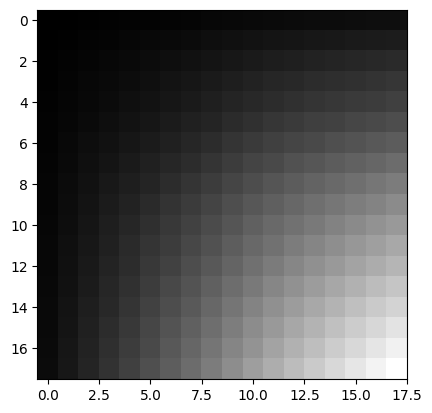

In [383]:
plt.imshow(iimgs[0], cmap = "gray")

## 4. Haar-like feature 계산 함수 

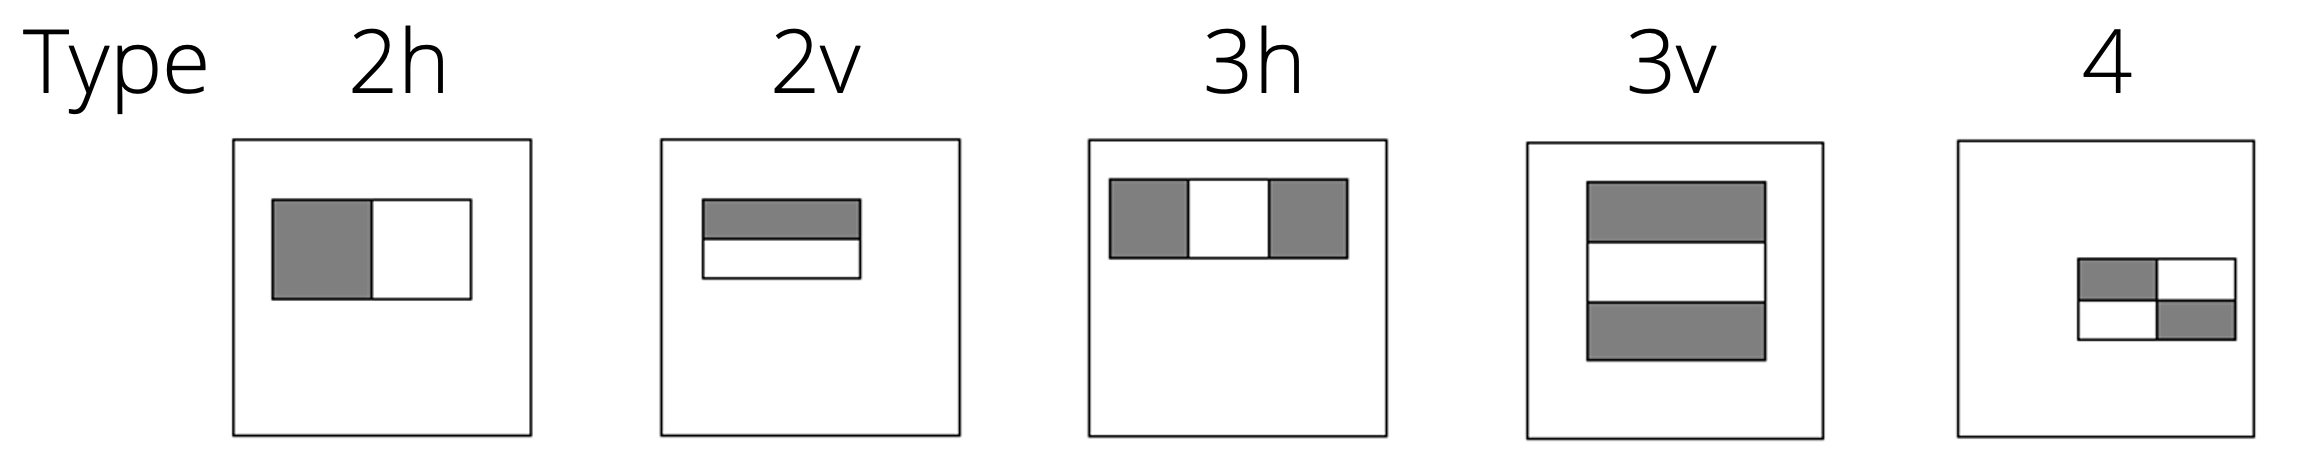

1. 위 그림과 같이 5종류의 Haar-like feature 형태를 적용하고, 각 feature 종류마다 가능한 위치/크기 값 x, y, w, h을 shape = (n_feat x 4)인 ndarray 형태로 도출하는 함수를 구현하시오.
   이때 각 feature마다 모든 사각 영역의 크기는 정수 값을 가지며, feature 종류마다 음/양 분할된 사각 영역은 반드시 동일한 크기를 갖도록 하시오.

2. 각 feature 종류별로 주어진 image dataset의 shape (n_image x w_i x h_i) ndarray 및 feature 위치/크기의 shape (n_feat x 4) ndarray에 대해 feature 값을 모두 계산하는 함수를 구현하시오. 계산된 feature 값들은 shape (n_image x n_feat)의 ndarray 형태로 도출하시오.

In [384]:
# 1. 각 feature 종류마다 가능한 위치/크기 값 x, y, w, h을 shape = (개수 x 4)인 ndarray 형태로 도출하는 함수를 구현하시오.
# 추가 : feature 갯수가 너무 많아, w, h > 4 일 feature만 사용합니다.
feat2h_ps = student.get_feature_pos_sz_2h(hlf_sz)
feat2v_ps = student.get_feature_pos_sz_2v(hlf_sz)
feat3h_ps = student.get_feature_pos_sz_3h(hlf_sz)
feat3v_ps = student.get_feature_pos_sz_3v(hlf_sz)
feat4_ps = student.get_feature_pos_sz_4(hlf_sz)

In [385]:
print(len(feat2h_ps))
print(len(feat2v_ps))
print(len(feat3h_ps))
print(len(feat3v_ps))
print(len(feat4_ps))

3822
3822
2730
2730
1764


In [386]:
print(feat2h_ps.shape[0])
print(iimgs.shape[0])

3822
2000


2. 각 feature 종류별로 주어진 image dataset의 shape (n_image x w_i x h_i) ndarray 및 feature 위치/크기의 shape (n_feat x 4) ndarray에 대해 feature 값을 모두 계산하는 함수를 구현하시오. 계산된 feature 값들은 shape (n_image x n_feat)의 ndarray 형태로 도출하시오.

In [387]:
LOAD_SAVE_DATA = False
if not LOAD_SAVE_DATA:
    # 2. 각 feature 종류별로 feature 값을 모두 계산하는 함수를 구현하시오. 계산된 feature 값들은 shape (n_image x n_feat)의 ndarray 형태로 도출하시오.
    feat2h = student.compute_features_2h(feat2h_ps ,iimgs)
    feat2v = student.compute_features_2v(feat2v_ps ,iimgs)
    feat3h = student.compute_features_3h(feat3h_ps ,iimgs)
    feat3v = student.compute_features_3v(feat3v_ps ,iimgs)
    feat4 = student.compute_features_4(feat4_ps ,iimgs)

    # concatenate computed features
    feat = np.column_stack(([feat2h, feat2v, feat3h, feat3v, feat4]))
    np.save("feat.npy",feat)
else:
    feat = np.load("feat.npy")
num_feat_per_type = [feat2h_ps.shape[0], feat2v_ps.shape[0], feat3h_ps.shape[0], feat3v_ps.shape[0], feat4_ps.shape[0]]
print(sum(num_feat_per_type))

14868


In [388]:
print(feat.shape)
print(feat2h_ps.shape[0])
print(feat2h_ps.shape[0] + feat2v_ps.shape[0])

(2000, 14868)
3822
7644


## 5. 각 feature 별 threshold 및 sign 도출하여 weak classifier 생성 후 에러 계산

개별 영상 $I$에 대한 feature 값 $f(I)$이 임계값 $\theta$을 초과하는지 아닌지에 따라 얼굴인지 아닌지를 판별하게 된다. 이때 $f(I)$의 특성에 따라 $\theta$을 초과하는 경우가 배경이 될 수도 있으므로, 부호(극성) p 값도 +1/-1 중에 적절한 값을 가진다.

$$
h(I, f, p, \theta) = \begin{cases} 
    1 & \text{if }  p~f(I) < p~\theta \\  
    0 & \text{otherwise}
\end{cases}
$$

위에서 계산된 feat 행렬의 열에는 전체 영상의 개별 feature 계산 값이 저장되어 있는데, 이를 이용하여 각 feature 별로 아래 식에 따라 positive & negative 영상을 구분하는 임계값과 부호를 도출해 주는 함수를 작성하시오. 

참고: 임계값과 부호를 도출할 때에는 계산된 feature 값들을 정렬하고, 정렬된 feature 값들을 순서대로 확인하면서, 해당 feature 값을 초과/미만(부호에 따라)하는 feature 값을 갖는 positive/negative 영상들의 개수(weight)들의 총합을 고려하여 정하시오. 그리고 도출된 임계값 $\theta$와 부호 $p$을 통해 feature 별로 weak classifier가 완성되므로, 각 weak classifier 별 판별 오류를 계산하도록 하시오.

In [389]:
thetas, signs, errors = student.get_weak_classifiers(feat, labels, weights)

In [390]:
print(thetas)
print(signs)
print(errors)

[ 0.00126852  0.00105912  0.00178598 ... -0.0055301  -0.54606955
 -1.04147535]
[-1. -1. -1. ...  1.  1.  1.]
[708. 739. 774. ... 825. 616. 617.]


## 6. 최적의 weak classifier 도출
위에서 산출된 error 배열을 통해 최적의 weak classifier를 도출하고,  
해당 weak classifier의 haar-like feature를 영상 위에 겹쳐서 표기하는 함수 student.overlay_haar_feature를 구현하시오.

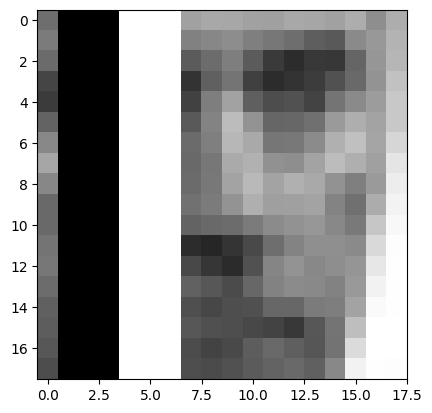

In [435]:
import random
# 계산된 weak classifier 별 error 값들을 기반으로 최적의 weak classifier의 위치, 크기, 및 종류를 반환하는 함수 get_best_weak_classifier()를 구현하시오.
h_x, h_y, h_w, h_h, h_type = student.get_best_weak_classifier(errors, num_feat_per_type, feat2h_ps, feat2v_ps, feat3h_ps, feat3v_ps, feat4_ps) 

img = data[random.randint(0,n_p),:,:]
# 도출된 최적 weak classifier의 Haar-like feature을 임의의 얼굴 영상 위에 겹쳐서 시각화하는 함수 overlay_haar_feature()를 구현하시오.
hlf_img = student.overlay_haar_feature(hlf_sz, h_x, h_y, h_w, h_h, h_type, img/np.max(img))

plt.imshow(hlf_img, cmap='gray')